## A Nighttime Light (NTL) Analysis of the Turkish Economy

This is an overview of my study (more details at https://youtu.be/CCL3_KghIaM) of the correlation between GDP and nighttime light in Turkey.

For a basic tutorial, see https://worldbank.github.io/OpenNightLights/welcome.html

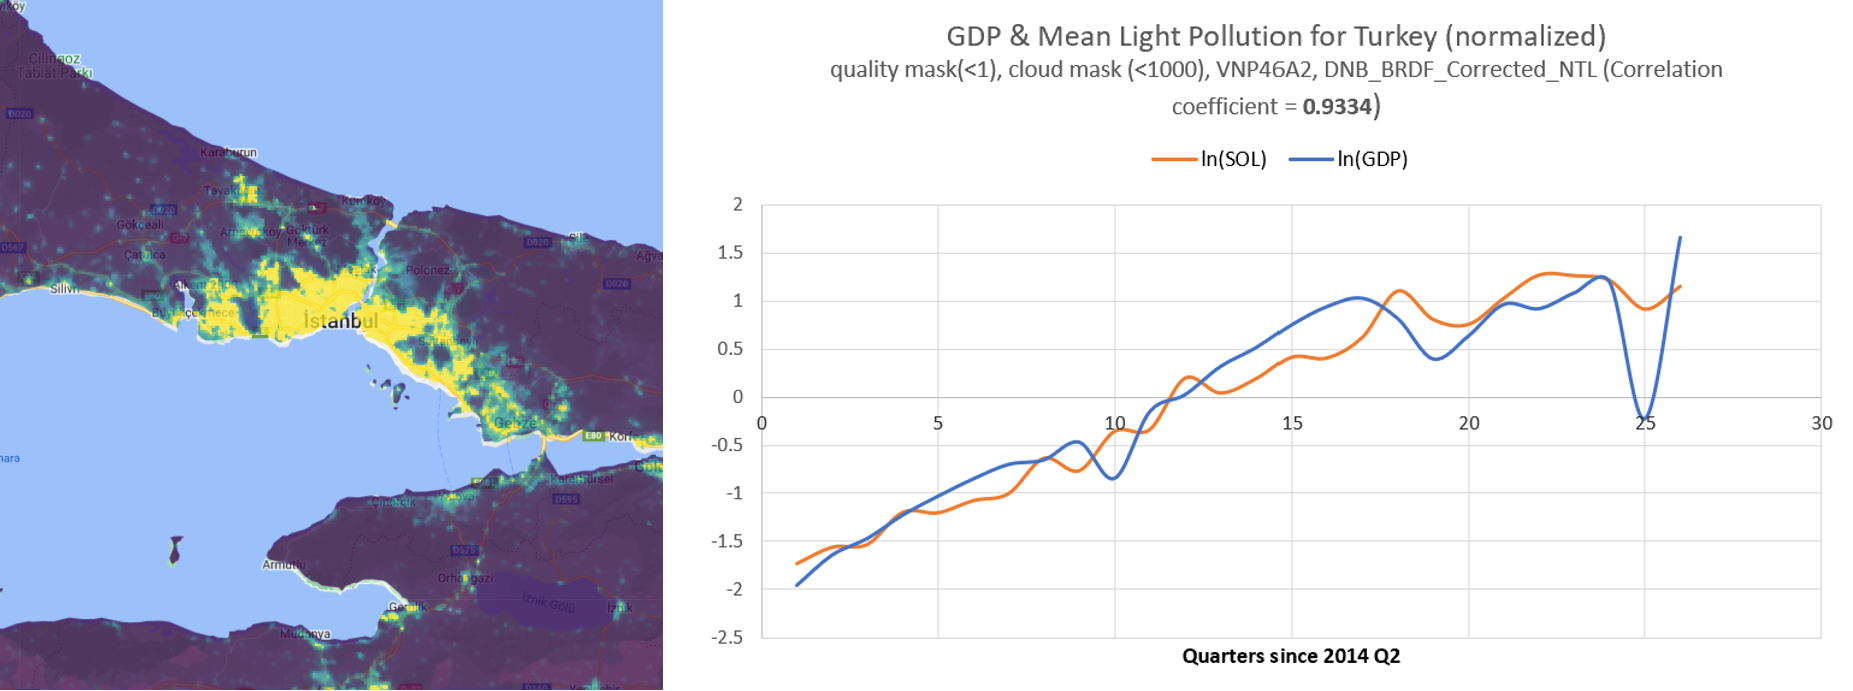

When running this code for the first time, you will be prompted to provide a code to authenticate Google Earth Engine. Follow the instructions provided by the link which appears.

In [17]:
try:
    import geemap
    import ee
except ModuleNotFoundError:
    print('Install geemap to proceed.')

# Initialize Google Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To clean the data, we will have to create a custom mask out of the 2015 & 2016 EOG annual composites. Start by downloading the GeoTIFF packages with coordinates 75N060E & 75N060W from https://eogdata.mines.edu/nighttime_light/annual/v10/. 

Use [rio-cogeo](https://cogeotiff.github.io/rio-cogeo/) to convert the 'vcm-orm-ntl' GeoTIFFs into Cloud-Optimized GeoTIFFs (COGs) and upload them to Google Cloud with the directory format below. I added the -COG suffix to my COGs.

NB: The mask we use in this project only covers Europe and Asia. To apply this method to other regions, simply download the required files and combine them as below.

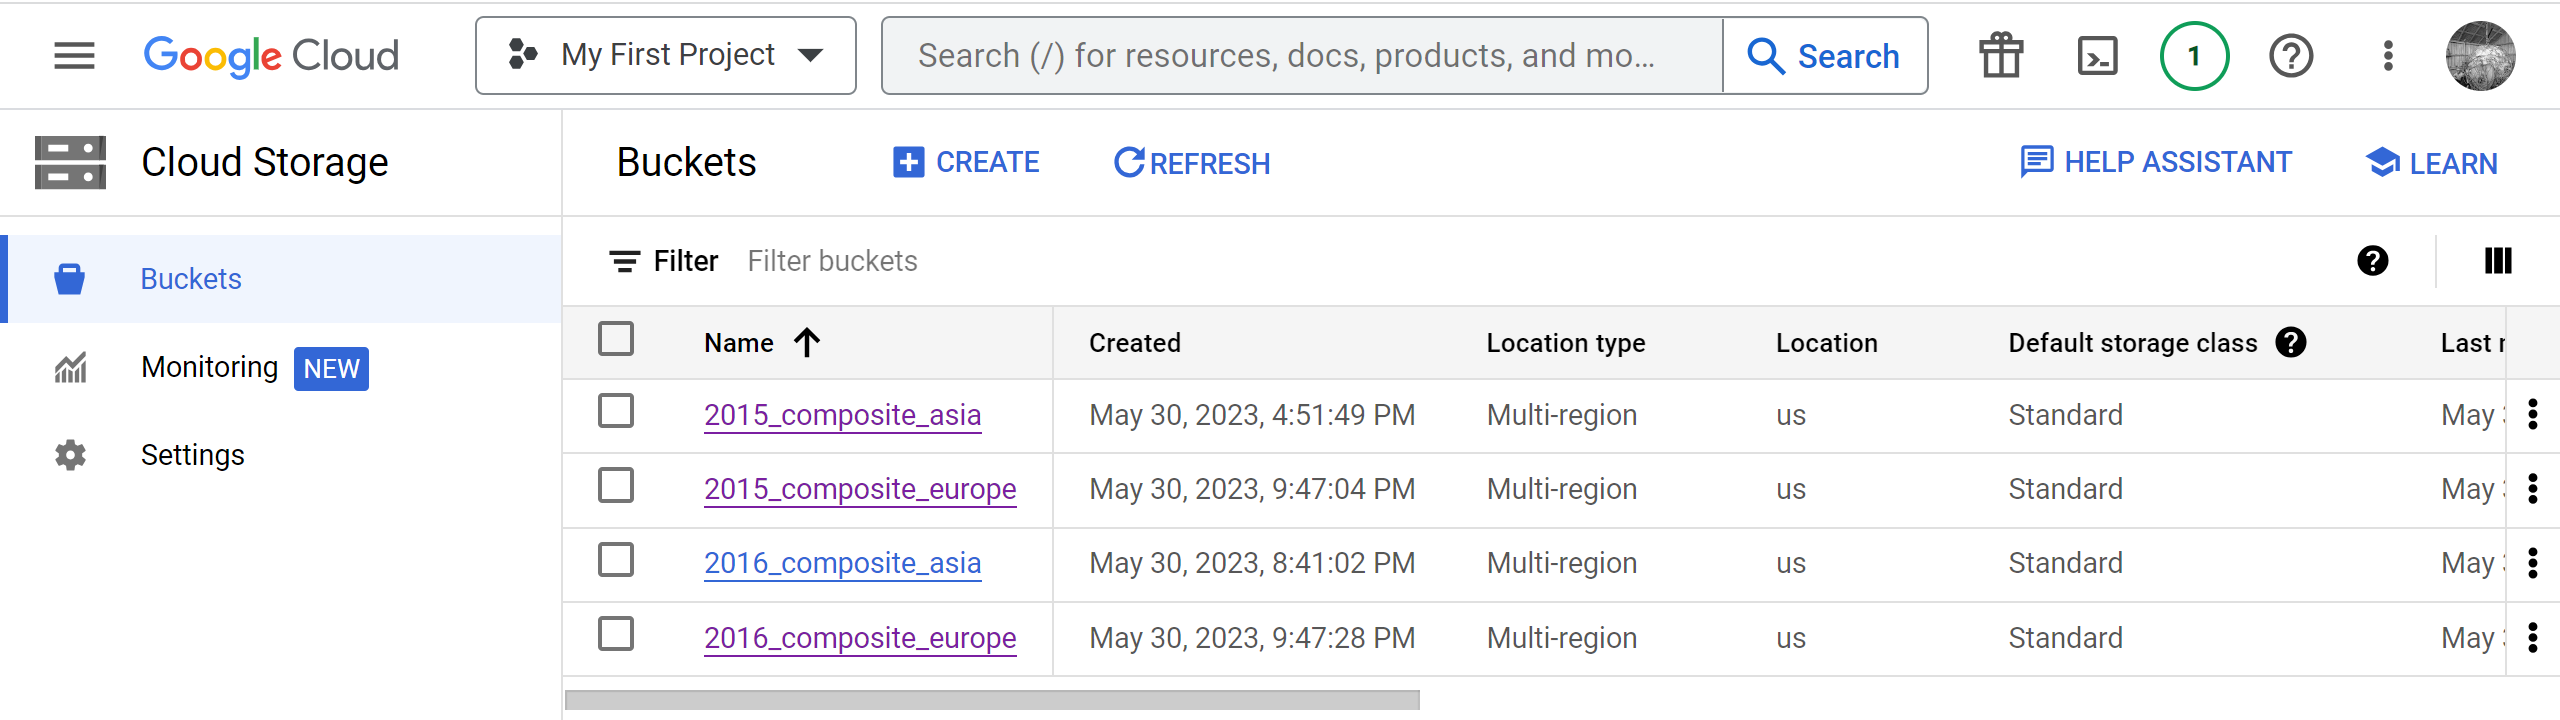

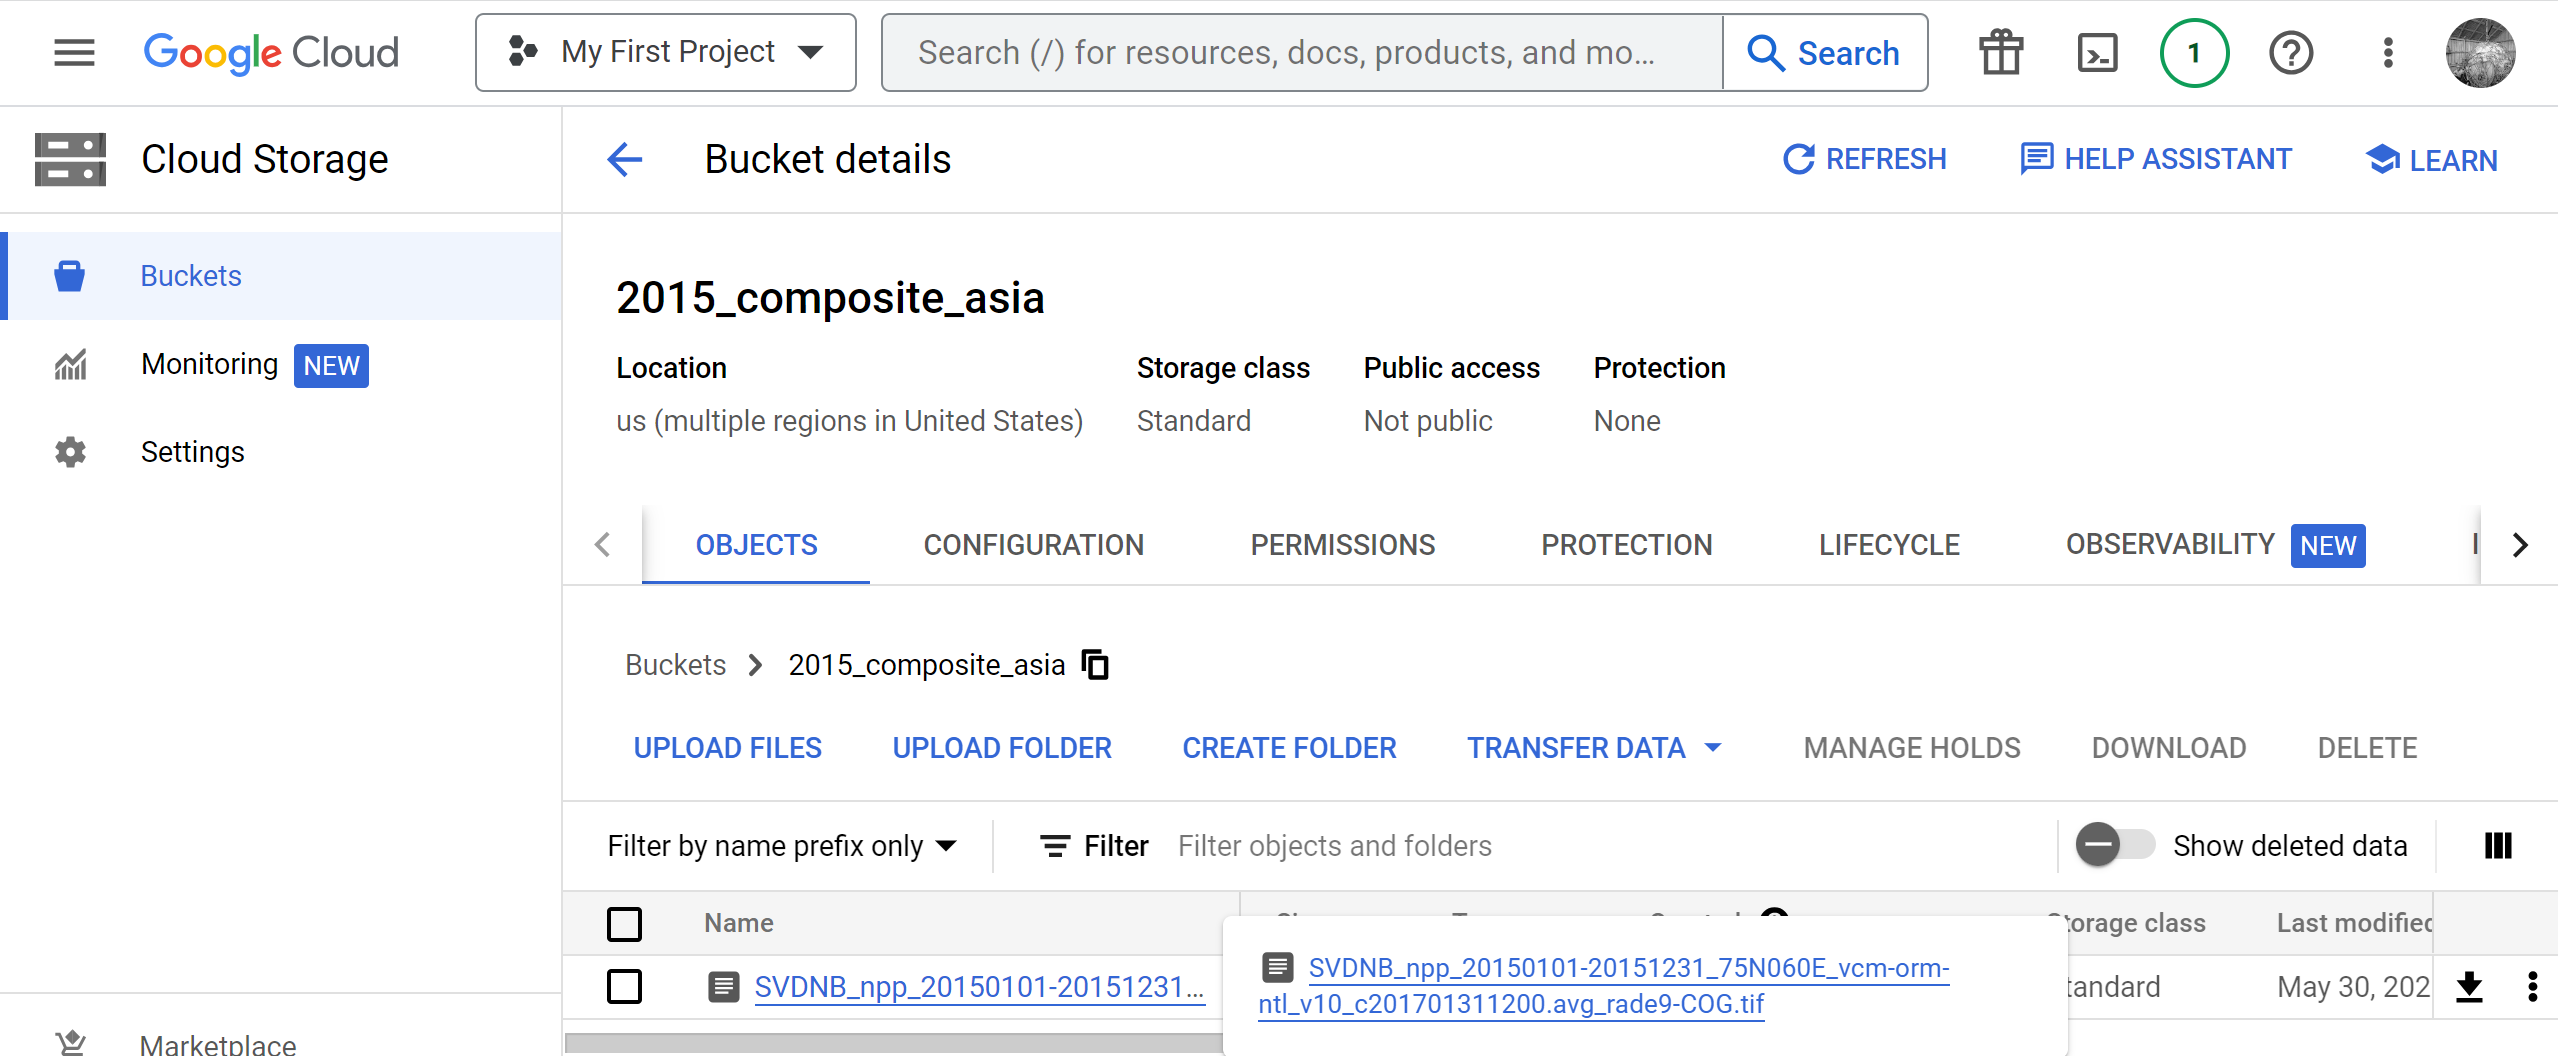

In [2]:
# Imports annual composites for Europe & Asia
import geemap, ee
ee.Initialize()
vcm_orm_ntl_2015_asia = ee.Image.loadGeoTIFF("gs://2015_composite_asia/SVDNB_npp_20150101-20151231_75N060E_vcm-orm-ntl_v10_c201701311200.avg_rade9-COG.tif")
vcm_orm_ntl_2016_asia = ee.Image.loadGeoTIFF("gs://2016_composite_asia/SVDNB_npp_20160101-20161231_75N060E_vcm-orm-ntl_v10_c201807311200.avg_rade9-COG.tif")
vcm_orm_ntl_2015_europe = ee.Image.loadGeoTIFF("gs://2015_composite_europe/SVDNB_npp_20150101-20151231_75N060W_vcm-orm-ntl_v10_c201701311200.avg_rade9-COG.tif")
vcm_orm_ntl_2016_europe = ee.Image.loadGeoTIFF("gs://2016_composite_europe/SVDNB_npp_20160101-20161231_75N060W_vcm-orm-ntl_v10_c201807311200.avg_rade9-COG.tif")

continent_collection_2015 = ee.ImageCollection([vcm_orm_ntl_2015_asia, vcm_orm_ntl_2015_europe])
continent_collection_2016 = ee.ImageCollection([vcm_orm_ntl_2016_asia, vcm_orm_ntl_2016_europe])

mosaic_2015 = continent_collection_2015.mosaic()
mosaic_2016 = continent_collection_2016.mosaic()

eog_mask = mosaic_2015.add(mosaic_2016)
eog_mask = eog_mask.mask(eog_mask)

Below, we can visually compare the difference in NTL data reported by the DMSP and VIIRS satellites. Notice how the VIIRS data (right-hand side) avoids the 'bleaching' effect apparent in the DMSP data (left-hand side) as you zoom into the city-level.

In [3]:
turkey = ee.FeatureCollection("FAO/GAUL/2015/level0") \
            .filter(ee.Filter.eq('ADM0_NAME', 'Turkey'))

# DATE RANGE: 2012-01-19 - 2023-06-12
viirs_quarterly = ee.ImageCollection("NOAA/VIIRS/001/VNP46A2") \
                    .filterDate("2013-01-01","2013-12-31") \
                    .select('DNB_BRDF_Corrected_NTL') \
                    .median() \

# Imports DMSP 2013 annual composite
dmsp13 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F182013").select('stable_lights')

# Controls color scheme
vis_params = {
    'min':0,
    'max':60,
  'palette': ['380245', '23678b', '21908c', '39b185', 'fde725'],
  'opacity': 0.75
}

viirs_quarterly_tile = geemap.ee_tile_layer(viirs_quarterly.clip(turkey), vis_params, "VIIRS 2014 composite")
dmsp13_tile = geemap.ee_tile_layer(dmsp13.clip(turkey), vis_params, name="DMSP 2013 composite")

lat=38.9
lon=35
map3 = geemap.Map(center=[lat,lon],zoom=6)
map3.split_map(left_layer = dmsp13_tile, right_layer = viirs_quarterly_tile)

map3.addLayerControl()
map3

Map(center=[38.9, 35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Zooming into Instanbul, we should see the following:
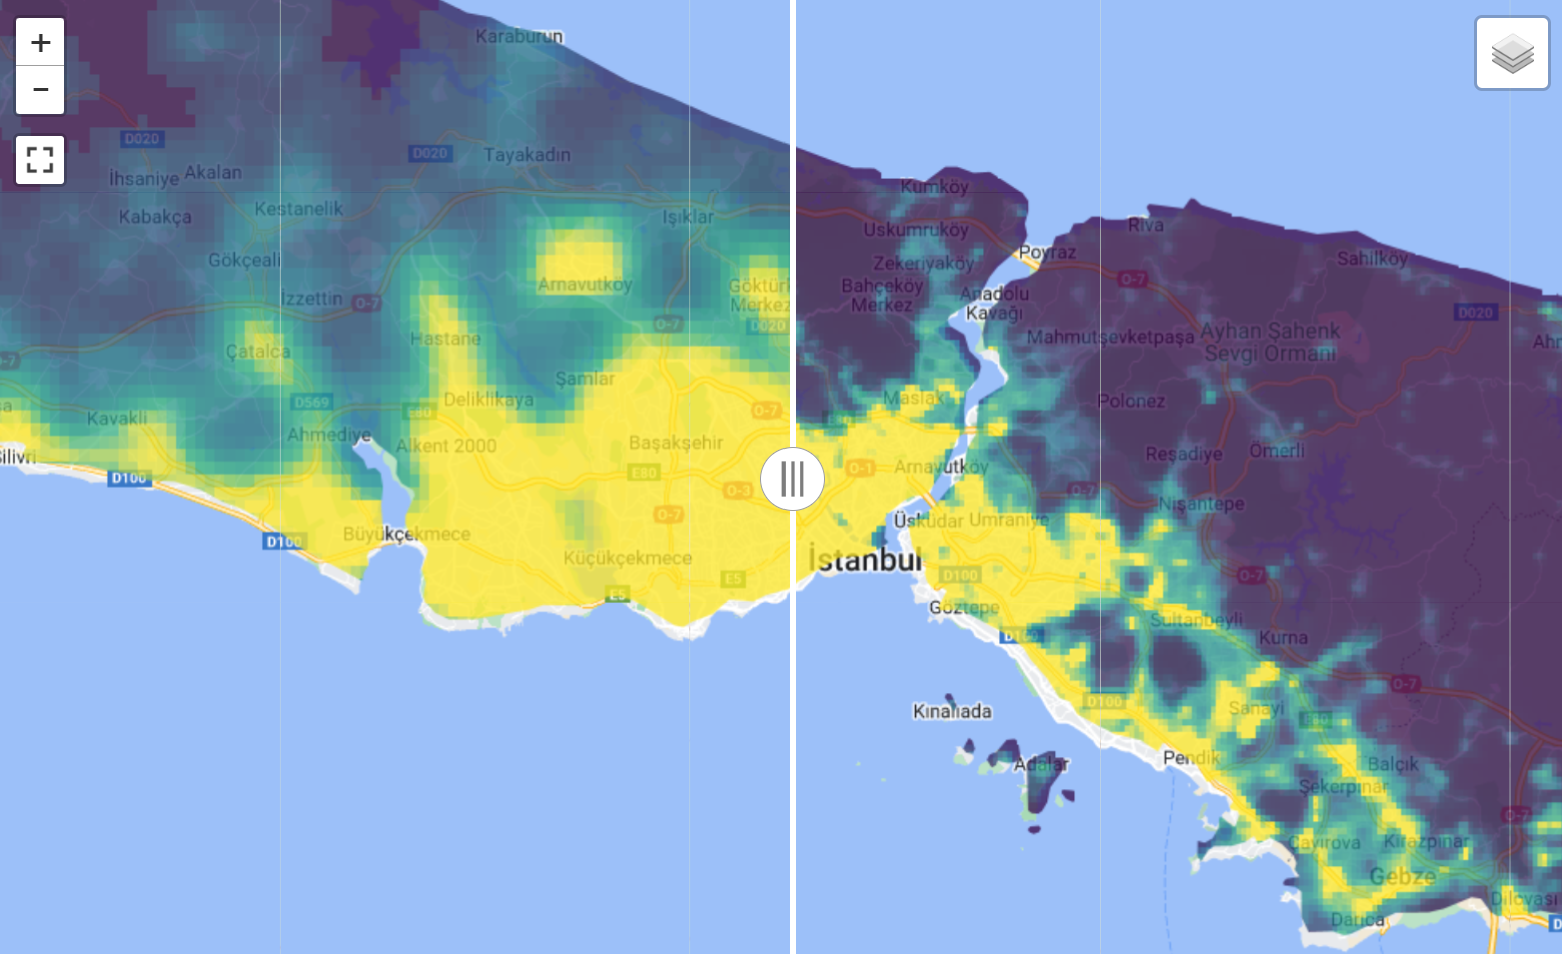

To analyse average nighttime light by quarter, we begin by defining a set of date boundaries:

In [4]:
dates = [
    "2014-02-15","2014-05-15", "2014-08-15","2014-11-15",
    "2015-02-15","2015-05-15", "2015-08-15","2015-11-15",
    "2016-02-15","2016-05-15", "2016-08-15","2016-11-15",
    "2017-02-15","2017-05-15", "2017-08-15","2017-11-15",
    "2018-02-15","2018-05-15", "2018-08-15","2018-11-15",
    "2019-02-15","2019-05-15", "2019-08-15","2019-11-15",
    "2020-02-15","2020-05-15", "2020-08-15"
]

Then, we define a function which applies reduceRegion() to our image set between the date boundaries and outputs average radiance. 

In [5]:
regionBeingAnalyzed = turkey

def print_mean_SOL(geemap_image):
    mean_SOL = geemap_image.reduceRegion(
                    reducer = ee.Reducer.mean(), 
                    geometry = regionBeingAnalyzed.geometry(),
                    scale = 500,
                    maxPixels = 1e11)
    
    for k, v in mean_SOL.getInfo().items():
        print(v)

In addition, we create a quality/cloud mask which screens out pixel-nights deemed to be corrupted. 

In [14]:
def mask_quality(image):
    quality_mask = image.select('Mandatory_Quality_Flag').lte(0)
    cloud_mask = image.select("QF_Cloud_Mask").lte(1000)
    combined_mask = quality_mask.And(cloud_mask)
    return image.updateMask(combined_mask)

Finally, we iterate through the dates, applying our masks to each dataset. 

In [16]:
for i in range (len(dates)-1):
    viirs = ee.ImageCollection("NOAA/VIIRS/001/VNP46A2") \
                        .filterDate(dates[i], dates[i+1]) \
                        .map(mask_quality) \
                        .select('DNB_BRDF_Corrected_NTL') \
                        .median() \
                        .mask(eog_mask)
    print_mean_SOL(viirs)
print('done')

3.0754468793466647
3.137719048170428
3.1484550313639317
3.2740680121900683
3.2720619428005593
3.3212894361615843
3.349672378673916
3.4973157825546037
3.444518064539801
3.6137060145037556
3.622200824765487
3.8559697032386677
3.7870232099090564
3.8525128213036908
3.9564670777993043
3.952271862875889
4.054405567296732
4.288586749588199
4.141742787542283
4.117602360665862
4.2509999401885175
4.373018029136196
4.369218502037363
4.344109657835274
4.194491021803125
4.312759966180509
done


We can collect this data into a table for analysis.
([GDP Source](https://fred.stlouisfed.org/series/NGDPRSAXDCTRQ))

| Quarter | GDP |$$\frac{\ln(\text{GDP})-\mu}{\sigma}$$| SOL |$$\frac{\ln(\text{SOL})-\mu}{\sigma}$$|
| :-: | :-: | :-: | :-: | :-: |
| 01/04/2014 | 379341 | -1.953029774 | 3.075446879 | -1.724151021 |
| 01/07/2014 | 388666 | -1.639218846 | 3.137719048 | -1.553909824 |
| 01/10/2014 | 393904 | -1.466246919 | 3.148455031 | -1.524901348 |
| 01/01/2015 | 401351 | -1.224200911 | 3.274068012 | -1.192660279 |
| 01/04/2015 | 407467 | -1.028780983 | 3.272061943 | -1.197865395 |
| 01/07/2015 | 413178 | -0.848931463 | 3.321289436 | -1.071048052 |
| 01/10/2015 | 417999 | -0.699019147 | 3.349672379 | -0.998780946 |
| 01/01/2016 | 419510 | -0.652384611 | 3.497315783 | -0.632469172 |
| 01/04/2016 | 425513 | -0.468792507 | 3.444518065 | -0.761656047 |
| 01/07/2016 | 413311 | -0.84477713 | 3.613706015 | -0.354438704 |
| 01/10/2016 | 436083 | -0.151733577 | 3.622200825 | -0.334498482 |
| 01/01/2017 | 442052 | 0.023954652 | 3.855969703 | 0.196632863 |
| 01/04/2017 | 452132 | 0.315313316 | 3.78702321 | 0.043407879 |
| 01/07/2017 | 458986 | 0.509733926 | 3.852512821 | 0.189015849 |
| 01/10/2017 | 467628 | 0.750766742 | 3.956467078 | 0.415137792 |
| 01/01/2018 | 474496 | 0.939180869 | 3.952271863 | 0.406127972 |
| 01/04/2018 | 477616 | 1.023869255 | 4.054405567 | 0.622803264 |
| 01/07/2018 | 469841 | 0.811772497 | 4.28858675 | 1.099687895 |
| 01/10/2018 | 454880 | 0.393620539 | 4.141742788 | 0.803801804 |
| 01/01/2019 | 463422 | 0.634022749 | 4.117602361 | 0.754157475 |
| 01/04/2019 | 475322 | 0.961651266 | 4.25099994 | 1.024927688 |
| 01/07/2019 | 473644 | 0.915967037 | 4.373018029 | 1.265260257 |
| 01/10/2019 | 479707 | 1.080310309 | 4.369218502 | 1.257878222 |
| 01/01/2020 | 483781 | 1.189598681 | 4.344109658 | 1.208932703 |
| 01/04/2020 | 433604 | -0.225381476 | 4.194491022 | 0.911278156 |
| 01/07/2020 | 501460 | 1.653411894 | 4.312759966 | 1.147423037 |

Applying statistical methods, we can calculate the Pearson correlation coefficient of the normalized datasets. $$r = \dfrac{\sum (x_i - \overline{x})(y_i - \overline{y})}{\sqrt{\sum (x_i - \overline{x})^2\sum(y_i - \overline{y})^2}} = 0.9334$$
This suggests nighttime lights are a highly reliable predictor of economic health. As studies such as [L. Martinez (2017)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3093296) have shown, we can use this to show that autocracies systematically overreport GDP growth more than democracies. 